In [1]:
from autocvd import autocvd
autocvd(num_gpus = 1)


import matplotlib.pyplot as plt
import numpy as np

import jax 
from jax import random
from jax import jit
import jax.numpy as jnp
from jax.sharding import Mesh, PartitionSpec, NamedSharding




from astropy import units as u
from astropy import constants as c
import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass, E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot, plot_sky_projection
from odisseo.potentials import NFW 



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



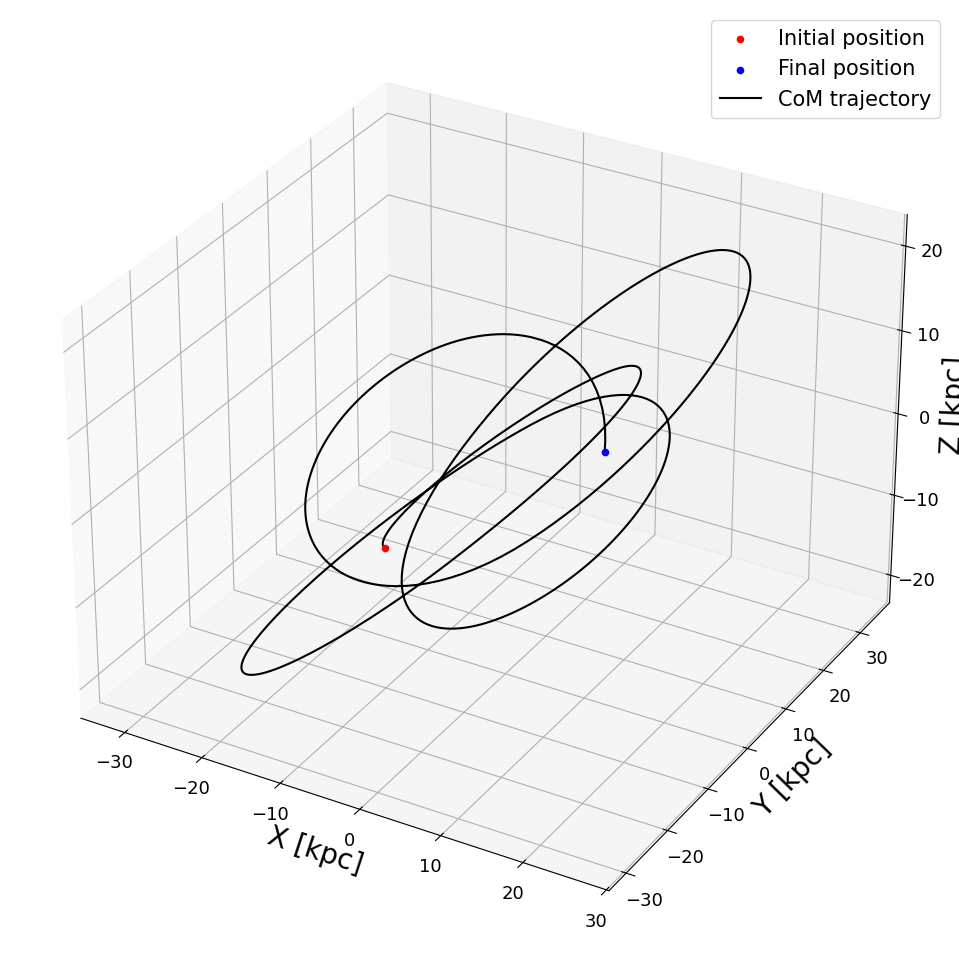

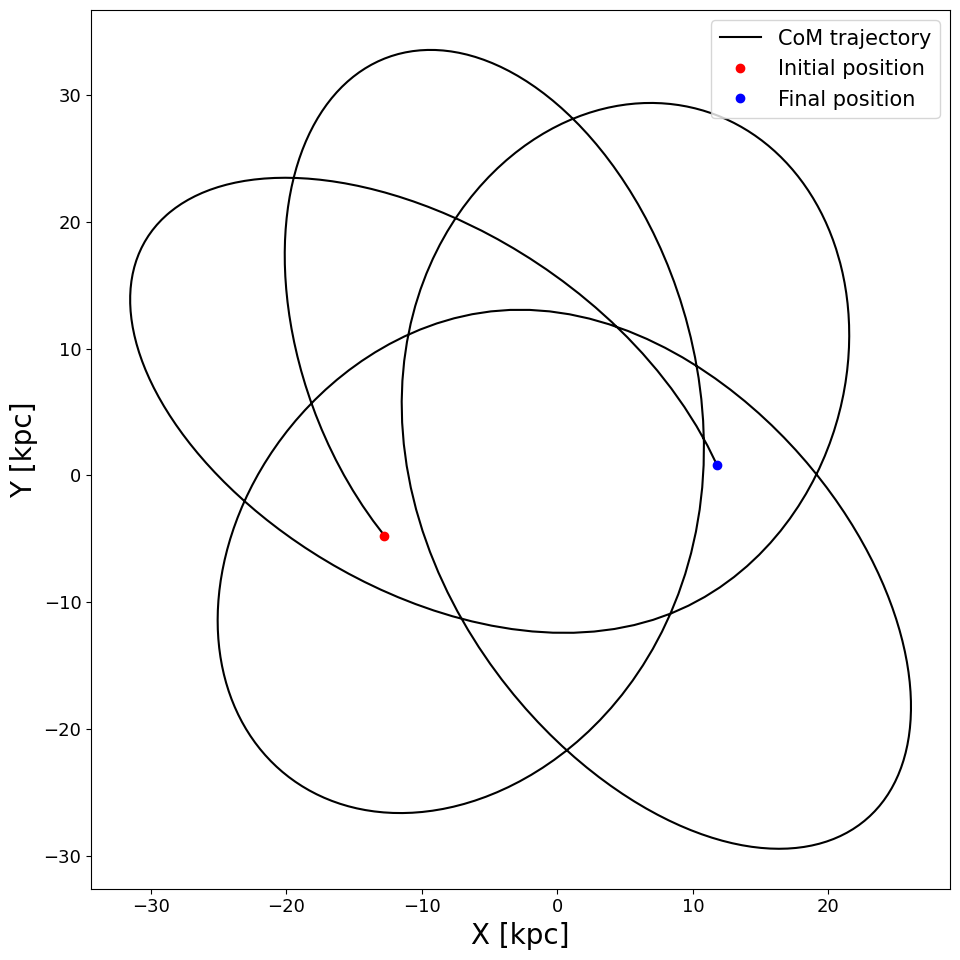

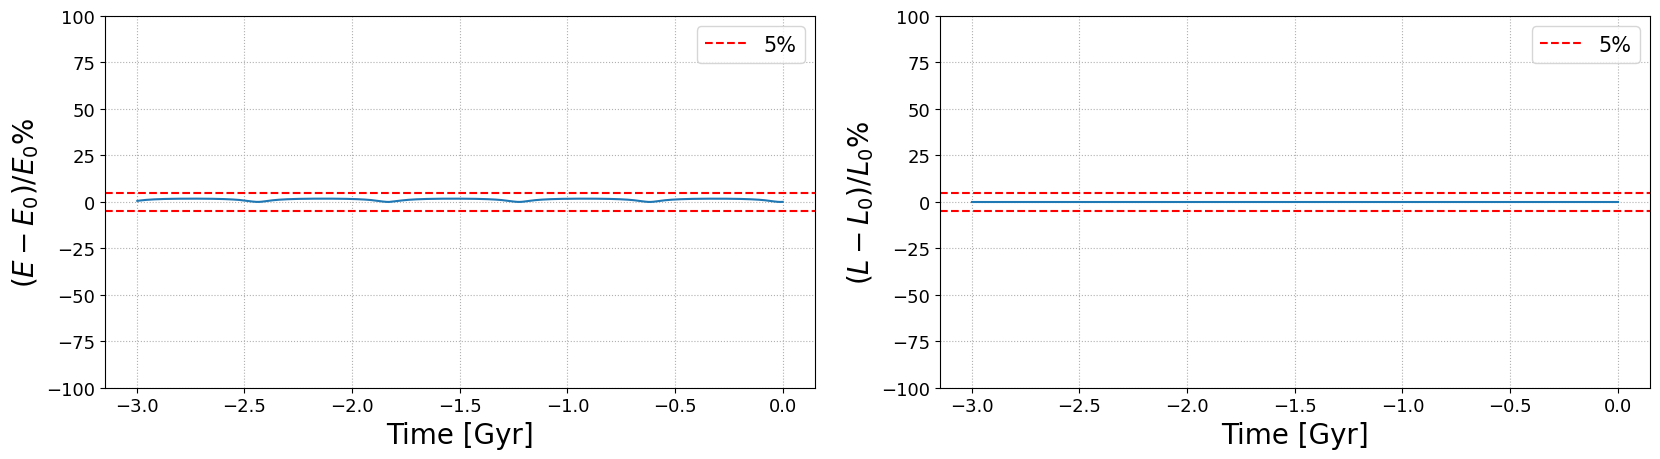

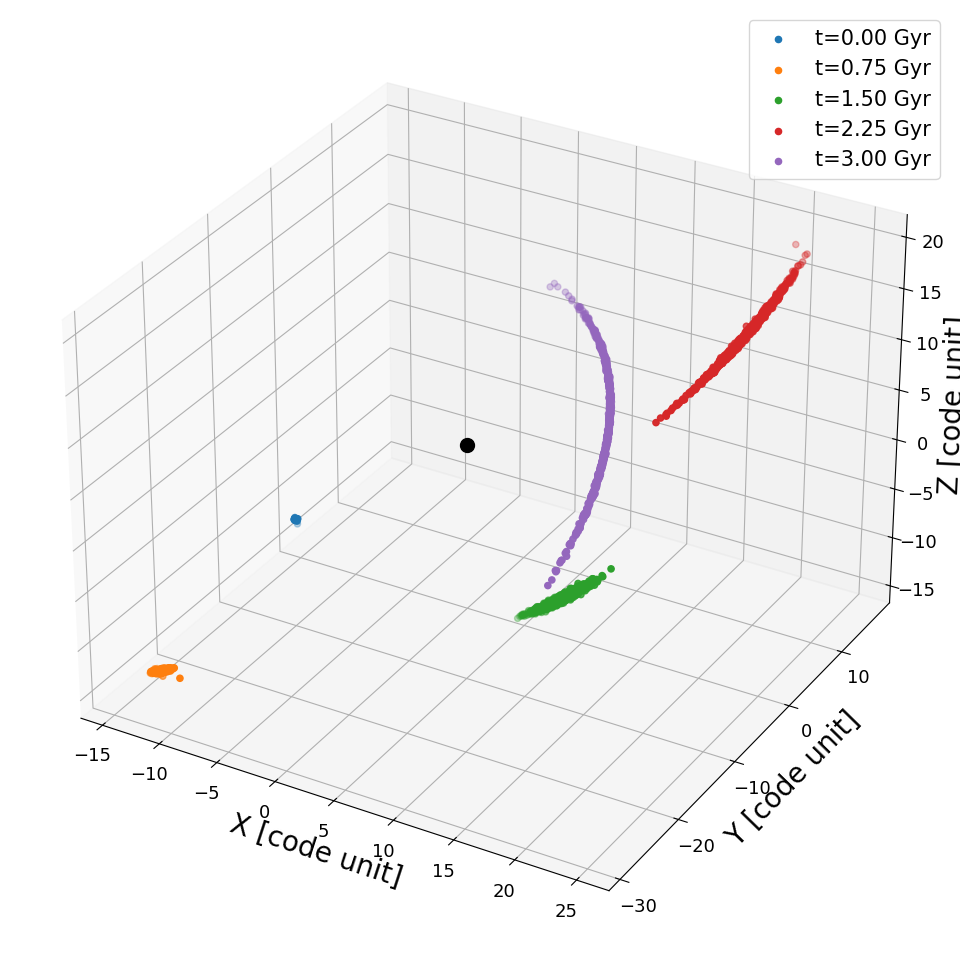

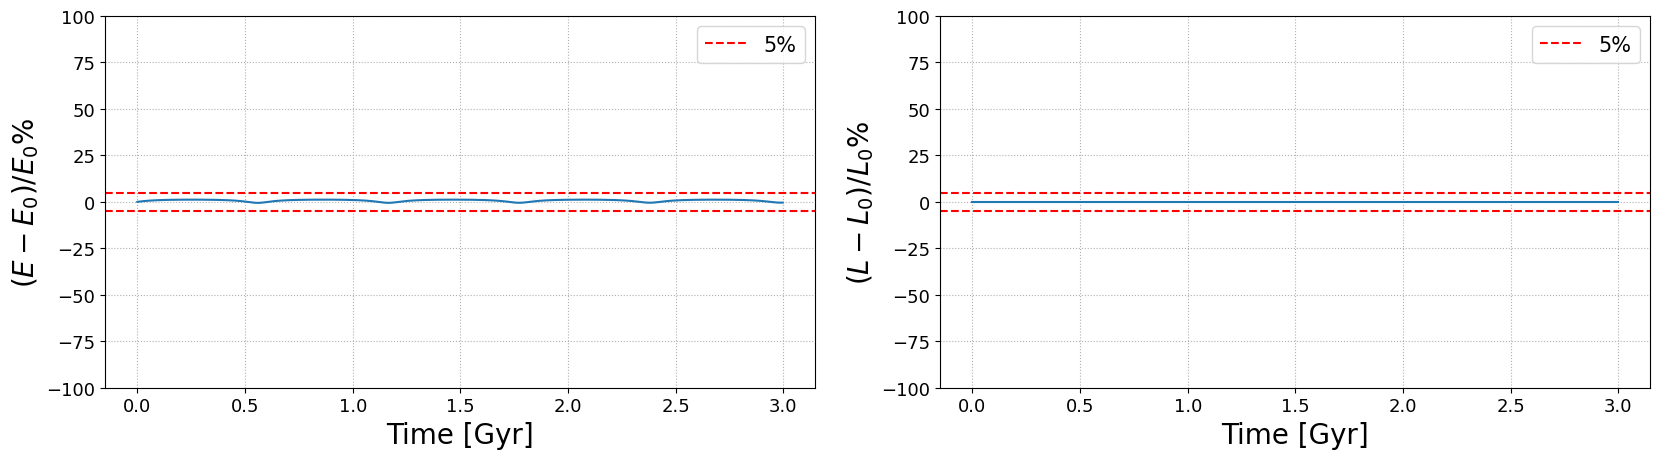

In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                        #   acceleration_scheme = DIRECT_ACC_MATRIX,
                          acceleration_scheme = NO_SELF_GRAVITY,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
# config_com = config._replace(return_snapshots=True,)
# config_com = config._replace(num_snapshots=500, )
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)



mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)



fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


In [4]:
target_stream = snapshots.states[-1]

In [ ]:
from jax.scipy.special import logsumexp

# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,
                         N_particles = 1000, 
                         softening = (0.1 * u.pc).to(code_units.code_length).value,
                         acceleration_scheme = NO_SELF_GRAVITY,
                        #  integrator = DIFFRAX_BACKEND,
                        #  fixed_timestep = False,
                        #  diffrax_solver = TSIT5,
                         )

config_com = config_com._replace(return_snapshots=False,
                                 acceleration_scheme = NO_SELF_GRAVITY,
                                #  integrator = DIFFRAX_BACKEND,
                                #  fixed_timestep = False,
                                #  diffrax_solver = TSIT5,
                                 )


# @jit
def time_integration_NFW_mass_grad(Mvir, key ):

    Mvir = 10**(Mvir)
    
   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(0)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    E_final = E_tot(final_state, mass, config, new_params)
    E_target = E_tot(target_stream, mass, config, new_params)   

    Angular_momentum_final = Angular_momentum(final_state, mass, )[:, 3]
    Angular_momentum_target = Angular_momentum(target_stream, mass, )[:, 3]
    # print(Angular_momentum_final.shape, Angular_momentum_target.shape)

    # return js_div_kde(E_final, E_target, n_eval_points=10_000, bandwidth=0.001)
    return jnp.exp(-0.1*js_div_kde(E_final, E_target, n_eval_points=10_000, bandwidth=0.001))

    # return js_div_kde(E_final, E_target, n_eval_points=100, bandwidth=0.0001) + js_div_kde(Angular_momentum_final, Angular_momentum_target, n_eval_points=1000, bandwidth=0.0001) 
    # return jax.sum(jax.vmap(js))
    # return js_div_kde(Angular_momentum_final, Angular_momentum_target, n_eval_points=100, bandwidth=0.1) 
    # return jnp.sum((Angular_momentum_final - Angular_momentum_target)**2)   
    # print(Angular_momentum_final.shape, Angular_momentum_target.shape)


# def gaussian_kde_1d(data, eval_points, bandwidth=0.1):
#     """
#     Compute 1D Gaussian KDE at evaluation points.
    
#     Args:
#         data: JAX array of data points
#         eval_points: JAX array of points where to evaluate the KDE
#         bandwidth: KDE bandwidth parameter
    
#     Returns:
#         KDE values at eval_points
#     """
#     # Reshape for broadcasting
#     data = data[:, None]  # (n_data, 1)
#     eval_points = eval_points[None, :]  # (1, n_eval)
    
#     # Gaussian kernel
#     kernel = jnp.exp(-0.5 * ((data - eval_points) / bandwidth) ** 2)
#     kernel = kernel / (bandwidth * jnp.sqrt(2 * jnp.pi))
    
#     # Sum over data points and normalize
#     kde = jnp.mean(kernel, axis=0)
#     return kde


def gaussian_kde_1d(data, eval_points, bandwidth=0.1):
    """
    Compute 1D Gaussian KDE at evaluation points.
    
    Args:
        data: JAX array of data points
        eval_points: JAX array of points where to evaluate the KDE
        bandwidth: KDE bandwidth parameter
    
    Returns:
        KDE values at eval_points
    """

    return jax.scipy.stats.gaussian_kde(data, ).evaluate(eval_points)

def js_div_kde(data1, data2, n_eval_points=100, bandwidth=0.1):
    """
    Calculate Jensen-Shannon divergence between two datasets using KDE.
    """
    # Create evaluation grid
    all_data = jnp.concatenate([data1.flatten(), data2.flatten()])
    data_min, data_max = jnp.min(all_data), jnp.max(all_data)
    eval_points = jnp.linspace(data_min, data_max, n_eval_points)
    
    # Compute KDE for both datasets
    kde1 = gaussian_kde_1d(data1.flatten(), eval_points, bandwidth)
    kde2 = gaussian_kde_1d(data2.flatten(), eval_points, bandwidth)
    
    # Normalize to probability distributions
    kde1 = kde1 / jnp.sum(kde1)
    kde2 = kde2 / jnp.sum(kde2)
    
    # Add small epsilon to avoid log(0)
    eps = 1e-8
    kde1 = kde1 + eps
    kde2 = kde2 + eps
    
    # Calculate JS divergence
    m = 0.5 * (kde1 + kde2)
    kl_1m = jnp.sum(kde1 * jnp.log(kde1 / m))
    kl_2m = jnp.sum(kde2 * jnp.log(kde2 / m))
    
    js_div = 0.5 * kl_1m + 0.5 * kl_2m
    return js_div
        
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = jnp.log10(params.NFW_params.Mvir*(3/4))
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

2025-09-21 10:16:56.280498: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 114.44MiB (rounded to 120000000)requested by op 
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-09-21 10:16:56.281710: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ****************************************************************************************************
E0921 10:16:56.281747  508324 pjrt_stream_executor_client.cc:2916] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 120000000 bytes. [tf-allocator-allocation-error='']


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 120000000 bytes.

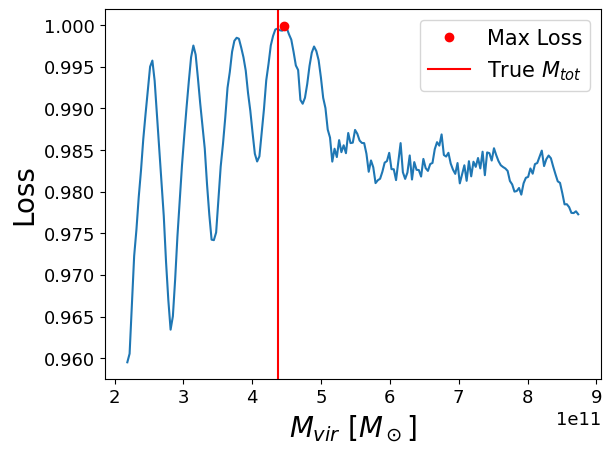

In [ ]:
n_sim = 199
keys = jnp.arange(n_sim+1)
Mvir = np.linspace(params.NFW_params.Mvir*(0.50), params.NFW_params.Mvir*(2.), n_sim) 
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir])]) # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

Mvir_sharded = jnp.log10(Mvir_sharded)

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_mass_grad_map(Mvir_and_key_NF):
    Mvir, key, = Mvir_and_key_NF
    return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key, )

loss, grad = jax.lax.map(
    time_integration_NFW_mass_grad_map, 
    (Mvir_sharded, keys_sharded), 
    batch_size=15
)

plt.figure()
plt.plot(Mvir*(code_units.code_mass).to(u.Msun), loss)
plt.plot(Mvir[jnp.argmax(loss)]*(code_units.code_mass).to(u.Msun), loss[jnp.argmax(loss)], 'ro', label='Max Loss')
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend() 


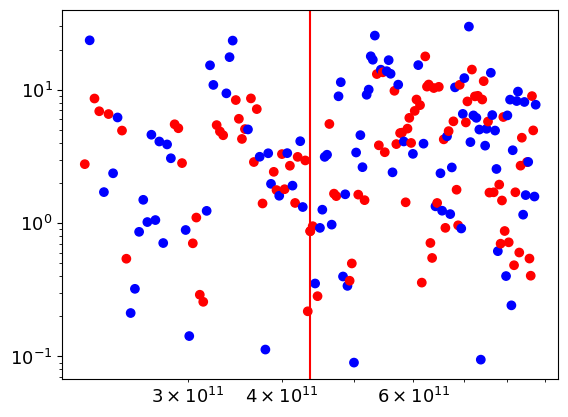

In [ ]:
plt.scatter(Mvir*(code_units.code_mass).to(u.Msun), jnp.sqrt(grad**2), c=np.where(grad>0, 'r', 'b'))
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xscale('log')
plt.yscale('log')